In [6]:
#!pip install catboost
#!pip install tensorflow

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings("ignore")

In [2]:
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import re

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('drive/MyDrive/diabetes/diabetes_data_encoded.csv').drop('Unnamed: 0', axis=1)
df

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted,...,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,5,1,41,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0,1,1,0
1,15,3,59,0,18,0,0,0,9,0,...,0,0,1,0,1,0,1,0,0,1
2,25,2,11,5,13,2,0,1,6,0,...,1,0,0,0,1,0,0,1,0,1
3,35,2,44,1,16,0,0,0,7,0,...,0,0,1,0,1,0,1,0,0,1
4,45,1,51,0,8,0,0,0,5,0,...,0,1,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97911,75,3,51,0,16,0,0,0,9,0,...,0,0,0,0,1,0,1,0,0,1
97912,85,5,33,3,18,0,0,1,9,0,...,0,1,0,0,1,0,0,1,0,1
97913,75,1,53,0,9,1,0,0,13,0,...,0,0,0,0,1,0,1,0,0,1
97914,85,10,45,2,21,0,0,1,9,0,...,0,0,1,0,1,0,1,0,0,1


In [5]:
class_counts = df['readmitted'].value_counts()
class1 = df[df['readmitted'] == 1]
class0 = df[df['readmitted'] == 0]
print(len(class0))
print(len(class1))


86950
10966


In [6]:
X = df.drop(['readmitted'], axis=1)
y = df['readmitted'].values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Lasso CV

In [7]:
lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)

LassoCV(cv=5)

In [8]:
selected_featuresLCV = lasso.coef_ > 0.05
feature_names = X_train.columns[selected_featuresLCV]
print('Original Feature Count:')
print(len(X_scaled.columns))
print('Feature count Lasso:')
print(len(feature_names))

feature_names = X.columns[selected_featuresLCV]
print('Selected Features: ', feature_names)


Original Feature Count:
1445
Feature count Lasso:
10
Selected Features:  Index(['number_emergency', 'number_inpatient', 'diag_1_250.41',
       'diag_1_250.42', 'diag_1_250.6', 'diag_1_250.7', 'diag_1_434',
       'diag_1_443', 'diag_1_787', 'diag_1_V58'],
      dtype='object')


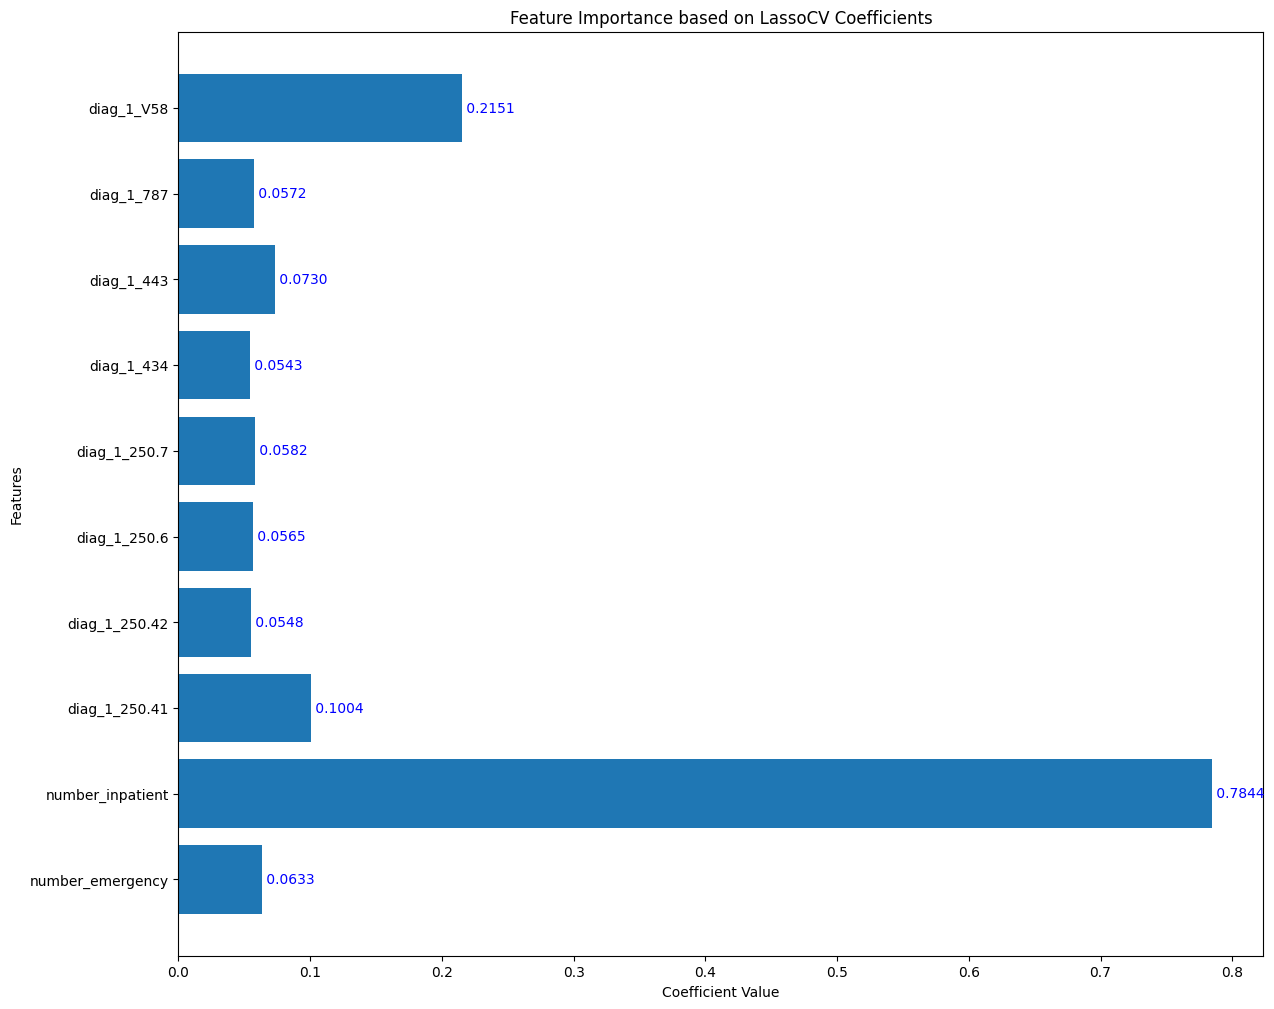

In [9]:
plt.figure(figsize=(14, 12))
ax =plt.barh(feature_names, lasso.coef_[selected_featuresLCV])
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importance based on LassoCV Coefficients')
for i, v in enumerate(lasso.coef_[selected_featuresLCV]):
    plt.text(v, i, f' {v:.4f}', color='blue', va='center')
plt.show()

Tree based Methods

In [10]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
feature_importancesRFC = pd.Series(rf.feature_importances_, index=X_train.columns.values)
selected_featuresRFC = feature_importancesRFC[feature_importancesRFC > 0.005].index
feature_names = X.columns[selected_featuresRFC]

In [11]:
print('Original Feature Count:')
print(len(X_scaled.columns))
print('Feature count RFC:')
print(len(selected_featuresRFC))
print('Selected Features: ')
feature_names

Original Feature Count:
1445
Feature count RFC:
37
Selected Features: 


Index(['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'race_AfricanAmerican',
       'race_Caucasian', 'gender_Female', 'gender_Male',
       'admission_type_id_Elective', 'admission_type_id_Emergency',
       'discharge_disposition_id_Discharged to Home',
       'discharge_disposition_id_Other', 'admission_source_id_Emergency',
       'admission_source_id_Other', 'admission_source_id_Referral',
       'A1Cresult_>8', 'A1Cresult_None', 'metformin_No', 'metformin_Steady',
       'glipizide_No', 'glipizide_Steady', 'glyburide_No', 'glyburide_Steady',
       'pioglitazone_No', 'insulin_Down', 'insulin_No', 'insulin_Steady',
       'insulin_Up', 'change_Ch', 'change_No', 'diabetesMed_No',
       'diabetesMed_Yes'],
      dtype='object')

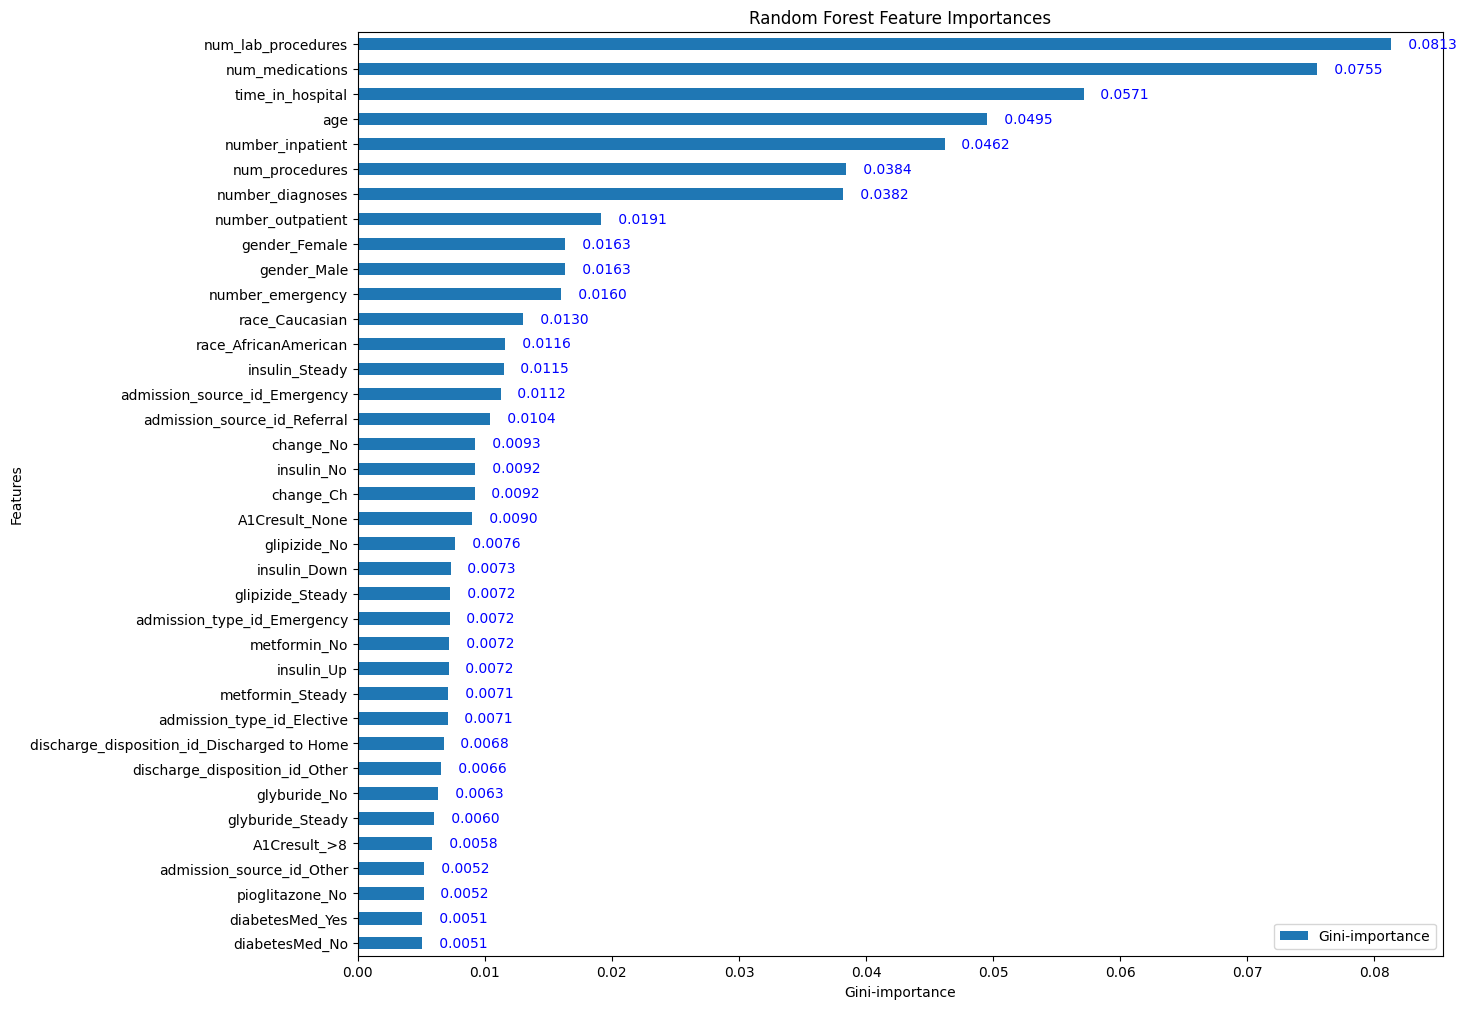

In [12]:
feats = {}
for feature, importance in zip(X.columns, rf.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
filtered_importances = importances[importances['Gini-importance'] > 0.005]
filtered_importances = filtered_importances.sort_values(by='Gini-importance')

# Plotting the filtered importances
ax = filtered_importances.plot(kind='barh', figsize = (14, 12))
plt.ylabel('Features')
plt.xlabel('Gini-importance')
plt.title('Random Forest Feature Importances')
for i, v in enumerate(filtered_importances.values):
    ax.text(v + 0.001, i, f' {v[0]:.4f}', color='blue', va='center')

plt.show()

In [13]:
train_data = lgb.Dataset(X_train, label=y_train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
}

num_round = 51
model = lgb.train(params, train_data, num_round)

feature_importancesLGBM = model.feature_importance(importance_type='gain')

sorted_indicesLGBM = np.argsort(feature_importancesLGBM)[::-1]
sorted_featuresLGBM = X_train.columns[sorted_indicesLGBM]

top_k = 20
selected_featuresLGBM = sorted_featuresLGBM[:top_k]

[LightGBM] [Info] Number of positive: 8787, number of negative: 69545
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.199476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1974
[LightGBM] [Info] Number of data points in the train set: 78332, number of used features: 846
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112176 -> initscore=-2.068701
[LightGBM] [Info] Start training from score -2.068701


In [14]:
print('Original Feature Count:')
print(len(X_scaled.columns))
print('Feature count LGBM:')
len(selected_featuresLGBM)

Original Feature Count:
1445
Feature count LGBM:


20

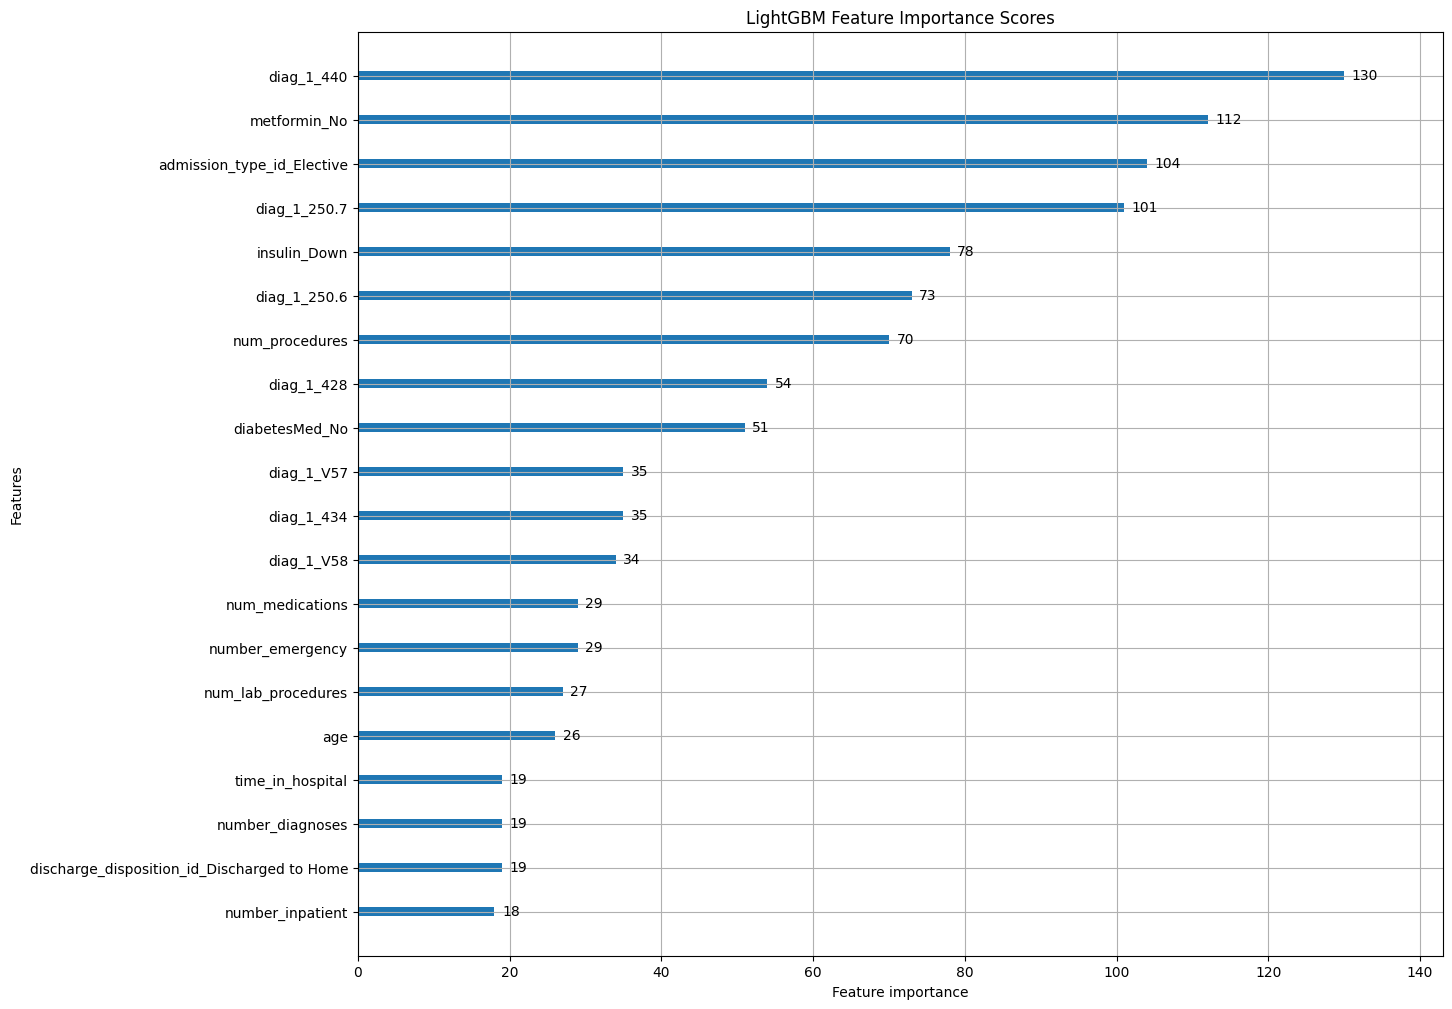

In [15]:
lgb.plot_importance(model, max_num_features=20, figsize=(14, 12))
feature_names = X.columns[selected_featuresLGBM]
plt.gca().set_yticklabels(feature_names)
plt.title('LightGBM Feature Importance Scores')
plt.show()

In [16]:
train = xgb.DMatrix(X_train, label=y_train)

params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'verbosity': 0
}

model = xgb.train(params, train, num_round)

# Feature Importance
feature_importancesXGB = model.get_score(importance_type='gain')

sorted_feature_importancesXGB = sorted(feature_importancesXGB.items(), key=lambda x: x[1], reverse=True)

top_k = 20
selected_featuresXGB = [feature[0] for feature in sorted_feature_importancesXGB[:top_k]]

In [17]:
print('Original Feature Count:')
print(len(X_scaled.columns))
print('Feature count XGB:')
len(selected_featuresXGB)

Original Feature Count:
1445
Feature count XGB:


20

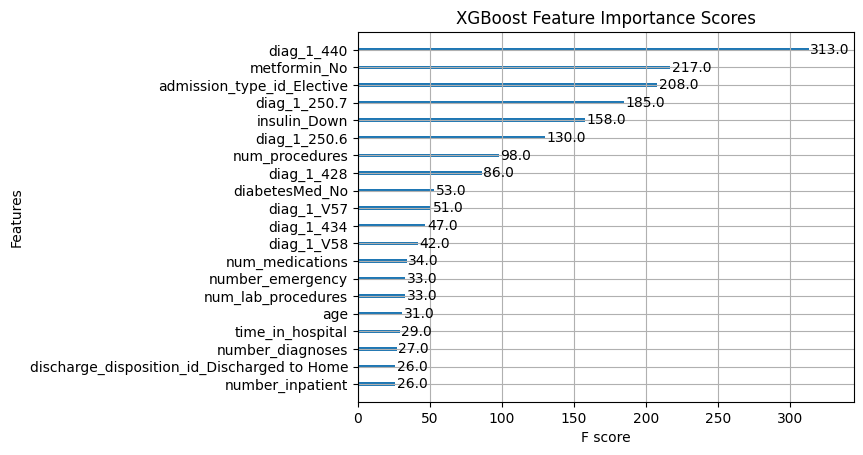

In [18]:
xgb.plot_importance(model, max_num_features=20)
feature_names = X.columns[selected_featuresLGBM]
plt.gca().set_yticklabels(feature_names)
plt.title('XGBoost Feature Importance Scores')
plt.show()

In [19]:
model = CatBoostClassifier(
    iterations=51,
    learning_rate=0.05,
    depth=6,
    verbose=False
)

model.fit(X_train, y_train)

feature_importancesCBC = model.get_feature_importance(type="PredictionValuesChange")

sorted_indicesCBC = np.argsort(feature_importancesCBC)[::-1]
sorted_featuresCBC = X_train.columns[sorted_indicesCBC]

top_k = 20
selected_importances = feature_importancesCBC[sorted_indicesCBC][:top_k]
selected_featuresCBC = sorted_featuresCBC[:top_k]

In [20]:
print('Original Feature Count:')
print(len(X_scaled.columns))
print('Feature count CBC:')
len(selected_featuresCBC)

Original Feature Count:
1445
Feature count CBC:


20

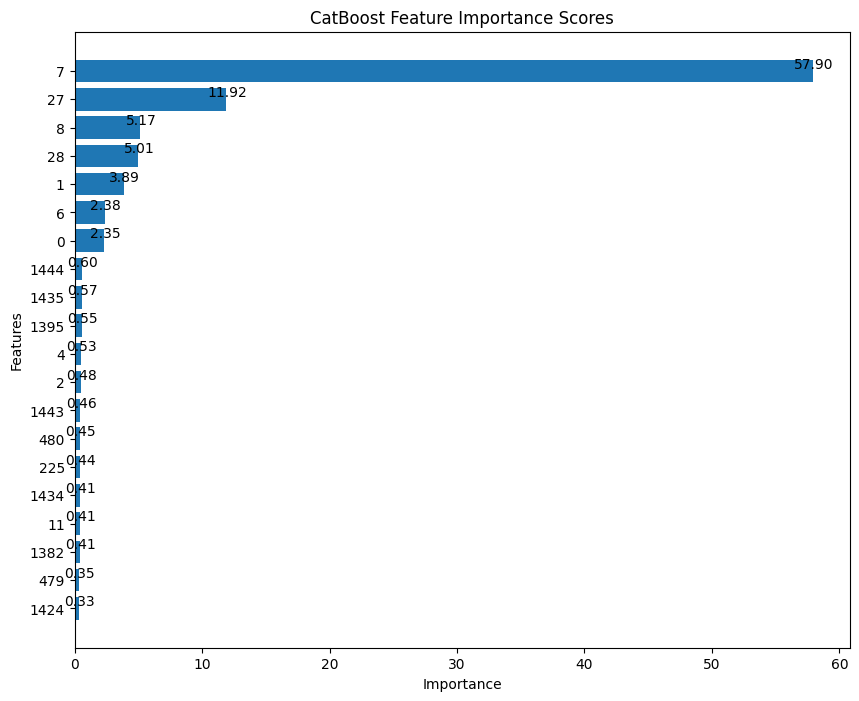

In [21]:
feature_importances_CBC = model.get_feature_importance(type="PredictionValuesChange")

# Get feature names and importance scores
feature_names = X_train.columns
sorted_indices = np.argsort(feature_importancesCBC)[::-1]
sorted_features = feature_names[sorted_indices]
top_k = 20
selected_features = sorted_features[:top_k]
selected_importances = feature_importances_CBC[sorted_indices][:top_k]

# Plotting CatBoost Feature Importance Scores
plt.figure(figsize=(10, 8))
bars = plt.barh(range(len(selected_features)), selected_importances[::-1], align='center')

# Display feature names on y-axis
plt.yticks(range(len(selected_features)), selected_features[::-1])

# Display values at the end of the bars
for bar, importance in zip(bars, selected_importances[::-1]):
    plt.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height() / 2, f'{importance:.2f}', ha='center', va='bottom')

plt.title('CatBoost Feature Importance Scores')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [22]:
feature_indices_LCV = X.columns[selected_featuresLCV]
feature_indices_RFC = X.columns[selected_featuresRFC]
feature_indices_LGBM = X.columns[selected_featuresLGBM]
feature_indices_XGB = X.columns[selected_featuresLGBM]
feature_indices_CBC = X.columns[selected_featuresLGBM]


common_features = set(feature_indices_LCV).intersection(set(feature_indices_RFC)).intersection(set(feature_indices_LGBM))
print("Feature Names from LassoCV:", feature_indices_LCV)
print("Feature Names from RandomForestClassifier:", feature_indices_RFC)
print("Feature Names from LightGBM:", feature_indices_LGBM)
print("Feature Names from XGBoost:", feature_indices_XGB)
print("Feature Names from CatBoost:", feature_indices_CBC)

common_features = set(feature_indices_RFC).intersection(set(feature_indices_LGBM)).intersection(set(feature_indices_XGB)).intersection(set(feature_indices_CBC))


Feature Names from LassoCV: Index(['number_emergency', 'number_inpatient', 'diag_1_250.41',
       'diag_1_250.42', 'diag_1_250.6', 'diag_1_250.7', 'diag_1_434',
       'diag_1_443', 'diag_1_787', 'diag_1_V58'],
      dtype='object')
Feature Names from RandomForestClassifier: Index(['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'race_AfricanAmerican',
       'race_Caucasian', 'gender_Female', 'gender_Male',
       'admission_type_id_Elective', 'admission_type_id_Emergency',
       'discharge_disposition_id_Discharged to Home',
       'discharge_disposition_id_Other', 'admission_source_id_Emergency',
       'admission_source_id_Other', 'admission_source_id_Referral',
       'A1Cresult_>8', 'A1Cresult_None', 'metformin_No', 'metformin_Steady',
       'glipizide_No', 'glipizide_Steady', 'glyburide_No', 'glyburide_Steady',
       'pioglitazone_No', 'insulin

In [23]:
print("Feature Names from all:", common_features)

Feature Names from all: {'admission_type_id_Elective', 'discharge_disposition_id_Discharged to Home', 'num_procedures', 'num_lab_procedures', 'age', 'insulin_Down', 'num_medications', 'metformin_No', 'number_inpatient', 'time_in_hospital', 'number_emergency', 'diabetesMed_No', 'number_diagnoses'}


In [24]:
feature_LCV = X[feature_indices_LCV]
feature_RFC = X[feature_indices_RFC]
feature_LGBM = X[feature_indices_LGBM]
feature_XGB = X[feature_indices_XGB]
feature_CBC = X[feature_indices_CBC]
common_features = X[common_features]
print(feature_LCV.shape)
print(feature_RFC.shape)
print(feature_LGBM.shape)
print(feature_XGB.shape)
print(feature_CBC.shape)
print(common_features.shape)

(97916, 10)
(97916, 37)
(97916, 20)
(97916, 20)
(97916, 20)
(97916, 13)


Modeling

In [25]:
RandomForest_Model = RandomForestClassifier()
GradientBoosting_Model = GradientBoostingClassifier()
XGBClassifier_Model = XGBClassifier()
LightGBM_Model = lgb.LGBMClassifier(verbose=-1)
CatBoost_Model = CatBoostClassifier(verbose=0)

In [26]:
def ML(model) :
    global final, classification_reports
    model_name = type(model).__name__
    pipe = Pipeline([('scaler',MinMaxScaler()),
    ('classifier',model)])
    print('fitting', model_name)
    pipe.fit(X_train , y_train)
    print('fitted', model_name)

    y_pred = pipe.predict(X_test)

    accuracy = accuracy_score(y_test , y_pred)
    precision = precision_score(y_test , y_pred)
    recall = recall_score(y_test , y_pred)
    f1 = f1_score(y_test , y_pred)

    new_row = {'model':model_name,'accuracy':accuracy, 'precision':precision,'recall':recall ,'f1': f1 }
    final = pd.concat([final , pd.DataFrame(new_row, index =[0])])

    report = classification_report(y_test, y_pred,output_dict=True)
    metrics_0 = report.get('0', {'precision': 0, 'recall': 0, 'f1-score': 0})
    metrics_1 = report.get('1', {'precision': 0, 'recall': 0, 'f1-score': 0})
    new_row = {
    'model': model_name,

    'accuracy': accuracy,
    'precision_0': metrics_0['precision'],
    'recall_0': metrics_0['recall'],
    'f1-score_0': metrics_0['f1-score'],
    'precision_1': metrics_1['precision'],
    'recall_1': metrics_1['recall'],
    'f1-score_1': metrics_1['f1-score']
    }

    classification_reports = classification_reports.append(new_row, ignore_index=True)
    return classification_reports
models = [RandomForest_Model,GradientBoosting_Model,XGBClassifier_Model,LightGBM_Model, CatBoost_Model]


In [43]:
X_feature_LCV = feature_LCV
y = df['readmitted'].values
scaler = MinMaxScaler()
scaler.fit(X_feature_LCV)
X_scaled_feature_LCV = scaler.transform(X_feature_LCV)
X_scaled_feature_LCV = pd.DataFrame(X_scaled_feature_LCV)
X_train, X_test, y_train, y_test = train_test_split(X_scaled_feature_LCV, y, test_size=0.2, random_state=42)

final = pd.DataFrame({'model':[],'accuracy':[],'precision':[],'recall':[],'f1':[]})
classification_reports = pd.DataFrame({'model':[], 'accuracy':[],'precision_0':[], 'recall_0':[], 'f1-score_0':[],
                                       'precision_1':[], 'recall_1':[], 'f1-score_1':[]})



In [44]:
for model in models :
    classification_reports = ML(model)

fitting RandomForestClassifier
fitted RandomForestClassifier
fitting GradientBoostingClassifier
fitted GradientBoostingClassifier
fitting XGBClassifier
fitted XGBClassifier
fitting LGBMClassifier
fitted LGBMClassifier
fitting CatBoostClassifier
fitted CatBoostClassifier


In [45]:
final['features'] = 'LassoCV'
final_LCV = final

In [46]:
classification_reports['features']= 'LassoCV'
classification_reports_LCV = classification_reports

In [47]:
X_feature_RFC = feature_RFC
y = df['readmitted'].values
scaler = MinMaxScaler()
scaler.fit(X_feature_RFC)
X_scaled_feature_RFC = scaler.transform(X_feature_RFC)
X_scaled_feature_RFC = pd.DataFrame(X_scaled_feature_RFC)
X_train, X_test, y_train, y_test = train_test_split(X_scaled_feature_RFC, y, test_size=0.2, random_state=42)
final = pd.DataFrame({'model':[],'accuracy':[],'precision':[],'recall':[],'f1':[]})
classification_reports = pd.DataFrame({'model':[], 'accuracy':[],'precision_0':[], 'recall_0':[], 'f1-score_0':[],
                                       'precision_1':[], 'recall_1':[], 'f1-score_1':[]})



In [48]:
for model in models :
    classification_reports = ML(model)

fitting RandomForestClassifier
fitted RandomForestClassifier
fitting GradientBoostingClassifier
fitted GradientBoostingClassifier
fitting XGBClassifier
fitted XGBClassifier
fitting LGBMClassifier
fitted LGBMClassifier
fitting CatBoostClassifier
fitted CatBoostClassifier


In [50]:
final['features'] = 'RandomForest'
final_RFC = final
classification_reports['features']= 'RandomForest'
classification_reports_RFC = classification_reports
classification_reports_RFC

,model,accuracy,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1,features
0,RandomForestClassifier,0.888123,0.889583,0.997989,0.940673,0.396552,0.010555,0.020563,RandomForest
1,GradientBoostingClassifier,0.889042,0.889247,0.999655,0.941224,0.666667,0.005507,0.010924,RandomForest
2,XGBClassifier,0.888531,0.890388,0.997357,0.940842,0.477273,0.019275,0.037053,RandomForest
3,LGBMClassifier,0.888787,0.889417,0.999081,0.941065,0.515152,0.007802,0.015371,RandomForest
4,CatBoostClassifier,0.888787,0.890336,0.997759,0.940992,0.506329,0.018357,0.035430,RandomForest


In [51]:
X_feature_LGBM = feature_LGBM
y = df['readmitted'].values
scaler = MinMaxScaler()
scaler.fit(X_feature_LGBM)
X_scaled_feature_LGBM = scaler.transform(X_feature_LGBM)
X_scaled_feature_LGBM = pd.DataFrame(X_scaled_feature_LGBM)
X_train, X_test, y_train, y_test = train_test_split(X_scaled_feature_LGBM, y, test_size=0.2, random_state=42)
final = pd.DataFrame({'model':[],'accuracy':[],'precision':[],'recall':[],'f1':[]})
classification_reports = pd.DataFrame({'model':[], 'accuracy':[],'precision_0':[], 'recall_0':[], 'f1-score_0':[],
                                       'precision_1':[], 'recall_1':[], 'f1-score_1':[]})



In [52]:
for model in models :
    classification_reports = ML(model)

fitting RandomForestClassifier
fitted RandomForestClassifier
fitting GradientBoostingClassifier
fitted GradientBoostingClassifier
fitting XGBClassifier
fitted XGBClassifier
fitting LGBMClassifier
fitted LGBMClassifier
fitting CatBoostClassifier
fitted CatBoostClassifier


In [53]:
final['features'] = 'LightGBM'
final_LGBM = final
classification_reports['features']= 'LightGBM'
classification_reports_LGBM = classification_reports

In [54]:
X_feature_XGB = feature_XGB
y = df['readmitted'].values
scaler = MinMaxScaler()
scaler.fit(X_feature_XGB)
X_scaled_feature_XGB = scaler.transform(X_feature_XGB)
X_scaled_feature_XGB = pd.DataFrame(X_scaled_feature_XGB)
X_train, X_test, y_train, y_test = train_test_split(X_scaled_feature_XGB, y, test_size=0.2, random_state=42)
final = pd.DataFrame({'model':[],'accuracy':[],'precision':[],'recall':[],'f1':[]})
classification_reports = pd.DataFrame({'model':[], 'accuracy':[],'precision_0':[], 'recall_0':[], 'f1-score_0':[],
                                       'precision_1':[], 'recall_1':[], 'f1-score_1':[]})



In [55]:
for model in models :
    classification_reports = ML(model)

fitting RandomForestClassifier
fitted RandomForestClassifier
fitting GradientBoostingClassifier
fitted GradientBoostingClassifier
fitting XGBClassifier
fitted XGBClassifier
fitting LGBMClassifier
fitted LGBMClassifier
fitting CatBoostClassifier
fitted CatBoostClassifier


In [56]:
final['features'] = 'XGBoost'
final_XGB = final
classification_reports['features']= 'XGBoost'
classification_reports_XGB = classification_reports

In [57]:
X_feature_CBC = feature_CBC
y = df['readmitted'].values
scaler = MinMaxScaler()
scaler.fit(X_feature_CBC)
X_scaled_feature_CBC = scaler.transform(X_feature_CBC)
X_scaled_feature_CBC = pd.DataFrame(X_scaled_feature_CBC)
X_train, X_test, y_train, y_test = train_test_split(X_scaled_feature_CBC, y, test_size=0.2, random_state=42)
final = pd.DataFrame({'model':[],'accuracy':[],'precision':[],'recall':[],'f1':[]})
classification_reports = pd.DataFrame({'model':[], 'accuracy':[],'precision_0':[], 'recall_0':[], 'f1-score_0':[],
                                       'precision_1':[], 'recall_1':[], 'f1-score_1':[]})



In [58]:
for model in models :
    classification_reports = ML(model)

fitting RandomForestClassifier
fitted RandomForestClassifier
fitting GradientBoostingClassifier
fitted GradientBoostingClassifier
fitting XGBClassifier
fitted XGBClassifier
fitting LGBMClassifier
fitted LGBMClassifier
fitting CatBoostClassifier
fitted CatBoostClassifier


In [59]:
final['features'] = 'CatBoost'
final_CBC = final
classification_reports['features']= 'CatBoost'
classification_reports_CBC = classification_reports

In [27]:
X_feature = common_features
y = df['readmitted'].values
scaler = MinMaxScaler()
scaler.fit(X_feature)
X_scaled_feature = scaler.transform(X_feature)
X_scaled_feature = pd.DataFrame(X_scaled_feature)
X_train, X_test, y_train, y_test = train_test_split(X_scaled_feature, y, test_size=0.2, random_state=42)
final = pd.DataFrame({'model':[],'accuracy':[],'precision':[],'recall':[],'f1':[]})
classification_reports = pd.DataFrame({'model':[], 'accuracy':[],'precision_0':[], 'recall_0':[], 'f1-score_0':[],
                                       'precision_1':[], 'recall_1':[], 'f1-score_1':[]})



In [28]:
for model in models :
    classification_reports = ML(model)

fitting RandomForestClassifier
fitted RandomForestClassifier
fitting GradientBoostingClassifier
fitted GradientBoostingClassifier
fitting XGBClassifier
fitted XGBClassifier
fitting LGBMClassifier
fitted LGBMClassifier
fitting CatBoostClassifier
fitted CatBoostClassifier


In [29]:
final['features'] = 'Common'
classification_reports['features']= 'Common'

In [30]:
final

,model,accuracy,precision,recall,f1,features
0,RandomForestClassifier,0.886693,0.321429,0.016521,0.031427,Common
0,GradientBoostingClassifier,0.889195,0.736842,0.006425,0.012739,Common
0,XGBClassifier,0.888021,0.428571,0.019275,0.036891,Common
0,LGBMClassifier,0.889400,0.760000,0.008720,0.017241,Common
0,CatBoostClassifier,0.889093,0.555556,0.016062,0.031222,Common


from matplotlib import pyplot as plt
final['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final['f1'].plot(kind='hist', bins=20, title='f1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
final.groupby('model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final.plot(kind='scatter', x='accuracy', y='precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final.plot(kind='scatter', x='recall', y='f1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final['accuracy'].plot(kind='line', figsize=(8, 4), title='accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
final['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
final['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
final['f1'].plot(kind='line', figsize=(8, 4), title='f1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(final['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(final, x='accuracy', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(final['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(final, x='precision', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(final['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(final, x='recall', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(final['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(final, x='f1', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [111]:
classification_reports

,model,accuracy,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1,features
0,RandomForestClassifier,0.887970,0.889566,0.997817,0.940587,0.377049,0.010555,0.020536,Common
1,GradientBoostingClassifier,0.889042,0.889605,0.999138,0.941196,0.583333,0.009637,0.018962,Common
2,XGBClassifier,0.888583,0.889873,0.998161,0.940912,0.475410,0.013309,0.025893,Common
3,LGBMClassifier,0.888531,0.889788,0.998219,0.940890,0.465517,0.012391,0.024139,Common
4,CatBoostClassifier,0.888583,0.889873,0.998161,0.940912,0.475410,0.013309,0.025893,Common
5,RandomForestClassifier,0.888123,0.889583,0.997989,0.940673,0.396552,0.010555,0.020563,Common
6,GradientBoostingClassifier,0.889042,0.889247,0.999655,0.941224,0.666667,0.005507,0.010924,Common
7,XGBClassifier,0.888531,0.890388,0.997357,0.940842,0.477273,0.019275,0.037053,Common
8,LGBMClassifier,0.888787,0.889417,0.999081,0.941065,0.515152,0.007802,0.015371,Common
9,CatBoostClassifier,0.888787,0.890336,0.997759,0.940992,0.506329,0.018357,0.035430,Common


In [95]:
classification_reports_ = [classification_reports_LCV, classification_reports_RFC, classification_reports_LGBM, classification_reports_XGB, classification_reports_CBC, classification_reports_]
final_ = [final_LCV, final_RFC, final_LGBM, final_XGB, final_CBC, final_]

classification_reports_ = [pd.DataFrame(report) for report in classification_reports_]
final_ = [pd.DataFrame(final) for final in final_]

merged_classification_reports = pd.concat(classification_reports_,keys=['model','accuracy',	'precision_0', 'recall_0','f1-score_0','precision_1',	'recall_1',	'f1-score_1','features'] ,ignore_index=True)
merged_final = pd.concat(final_, keys=['model','accuracy',	'precision', 'recall','f1-score', 'features'],ignore_index=True)
merged_classification_reports.drop(0, axis=1, inplace=True)
merged_final.drop(0, axis=1, inplace=True)
classification_reports= merged_classification_reports.dropna()
final= merged_final.dropna()

In [98]:
classification_reports

,model,accuracy,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1,features
0,RandomForestClassifier,0.887970,0.889566,0.997817,0.940587,0.377049,0.010555,0.020536,LassoCV
1,GradientBoostingClassifier,0.889042,0.889605,0.999138,0.941196,0.583333,0.009637,0.018962,LassoCV
2,XGBClassifier,0.888583,0.889873,0.998161,0.940912,0.475410,0.013309,0.025893,LassoCV
3,LGBMClassifier,0.888531,0.889788,0.998219,0.940890,0.465517,0.012391,0.024139,LassoCV
4,CatBoostClassifier,0.888583,0.889873,0.998161,0.940912,0.475410,0.013309,0.025893,LassoCV
5,RandomForestClassifier,0.888123,0.889583,0.997989,0.940673,0.396552,0.010555,0.020563,RandomForest
6,GradientBoostingClassifier,0.889042,0.889247,0.999655,0.941224,0.666667,0.005507,0.010924,RandomForest
7,XGBClassifier,0.888531,0.890388,0.997357,0.940842,0.477273,0.019275,0.037053,RandomForest
8,LGBMClassifier,0.888787,0.889417,0.999081,0.941065,0.515152,0.007802,0.015371,RandomForest
9,CatBoostClassifier,0.888787,0.890336,0.997759,0.940992,0.506329,0.018357,0.035430,RandomForest


from matplotlib import pyplot as plt
classification_reports['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
classification_reports['precision_0'].plot(kind='hist', bins=20, title='precision_0')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
classification_reports['recall_0'].plot(kind='hist', bins=20, title='recall_0')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
classification_reports['f1-score_0'].plot(kind='hist', bins=20, title='f1-score_0')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
classification_reports.groupby('model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
classification_reports.groupby('features').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
classification_reports.plot(kind='scatter', x='accuracy', y='precision_0', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
classification_reports.plot(kind='scatter', x='precision_0', y='recall_0', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
classification_reports.plot(kind='scatter', x='recall_0', y='f1-score_0', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
classification_reports.plot(kind='scatter', x='f1-score_0', y='precision_1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
classification_reports['accuracy'].plot(kind='line', figsize=(8, 4), title='accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
classification_reports['precision_0'].plot(kind='line', figsize=(8, 4), title='precision_0')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
classification_reports['recall_0'].plot(kind='line', figsize=(8, 4), title='recall_0')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
classification_reports['f1-score_0'].plot(kind='line', figsize=(8, 4), title='f1-score_0')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['features'].value_counts()
    for x_label, grp in classification_reports.groupby('model')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('model')
_ = plt.ylabel('features')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(classification_reports['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(classification_reports, x='accuracy', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(classification_reports['features'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(classification_reports, x='accuracy', y='features', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(classification_reports['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(classification_reports, x='precision_0', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(classification_reports['features'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(classification_reports, x='precision_0', y='features', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

ERROR:root:Did not find quickchart key chart-ca703811-b5b7-4ec0-beda-17c85016e528 in chart cache
ERROR:root:Did not find quickchart key chart-ca703811-b5b7-4ec0-beda-17c85016e528 in chart cache
ERROR:root:Did not find quickchart key chart-ca703811-b5b7-4ec0-beda-17c85016e528 in chart cache
ERROR:root:Did not find quickchart key chart-ca703811-b5b7-4ec0-beda-17c85016e528 in chart cache
ERROR:root:Did not find quickchart key chart-128014a4-f27a-4591-b8af-017c8c68a8c2 in chart cache
ERROR:root:Did not find quickchart key chart-128014a4-f27a-4591-b8af-017c8c68a8c2 in chart cache
ERROR:root:Did not find quickchart key chart-ca703811-b5b7-4ec0-beda-17c85016e528 in chart cache


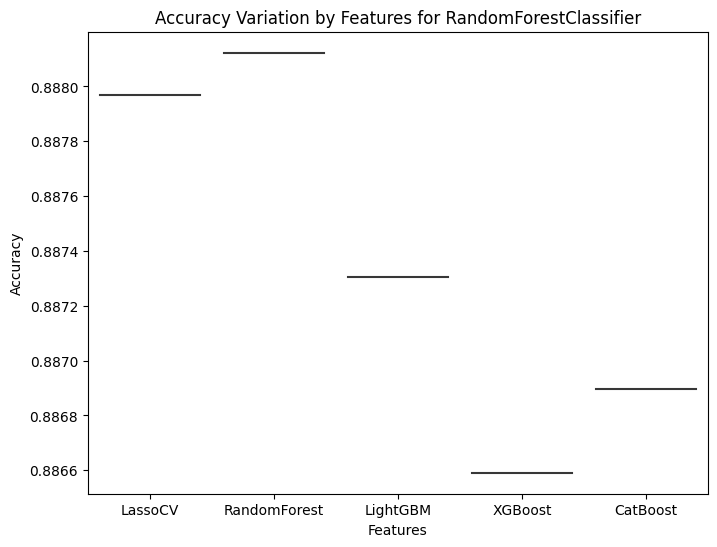

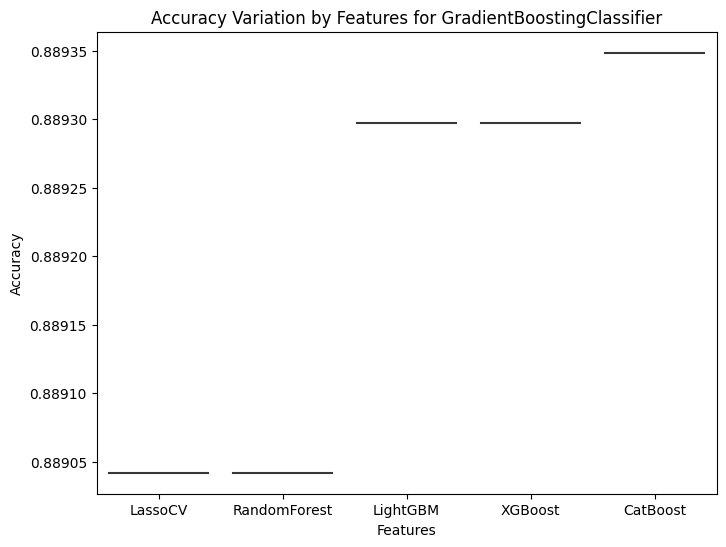

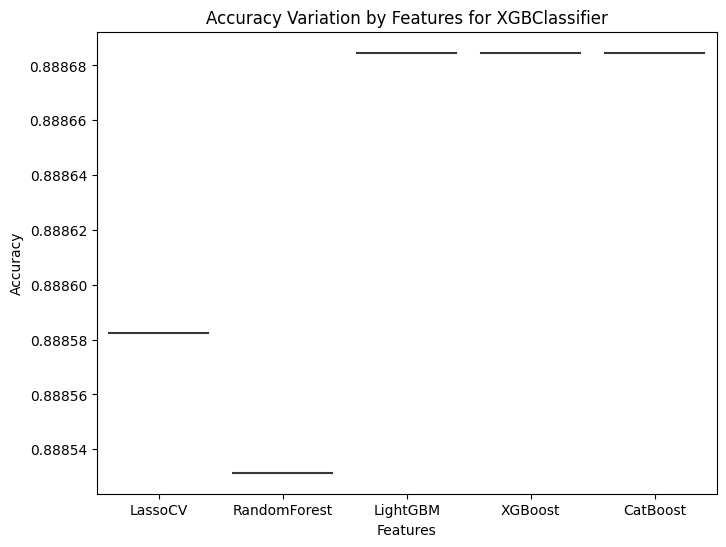

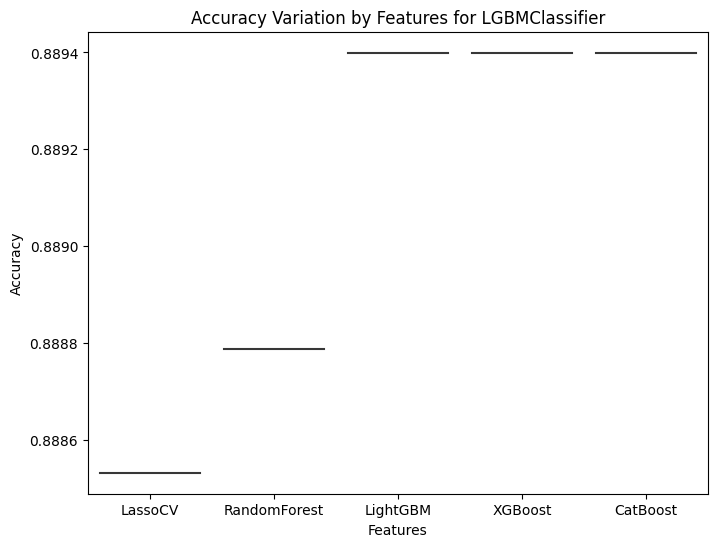

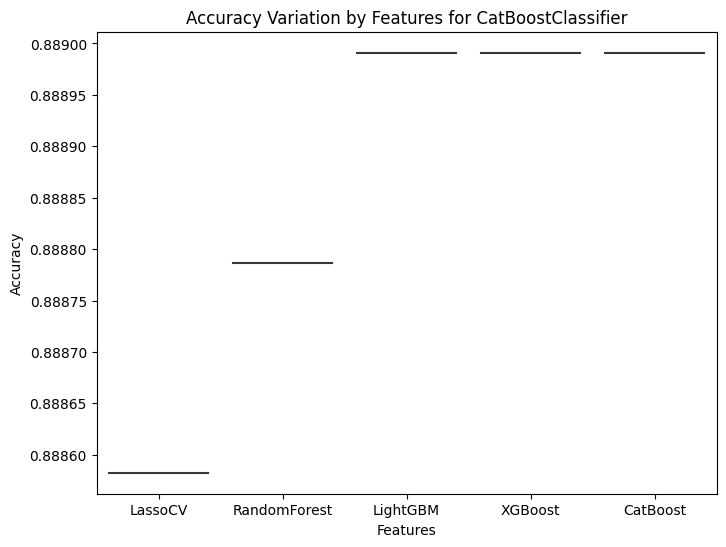

In [106]:
unique_models = classification_reports['model'].unique()

# Create individual violin plots for each model
for model in unique_models:
    plt.figure(figsize=(8, 6))  # Set figure size for each plot

    # Filter data for the current model
    model_data = classification_reports[classification_reports['model'] == model]

    # Create a violin plot for the current model
    sns.violinplot(data=model_data, x='features', y='accuracy', inner='stick', palette='Dark2')

    # Set title and labels
    plt.title(f'Accuracy Variation by Features for {model}')
    plt.xlabel('Features')
    plt.ylabel('Accuracy')

    # Show the plot
    plt.show()

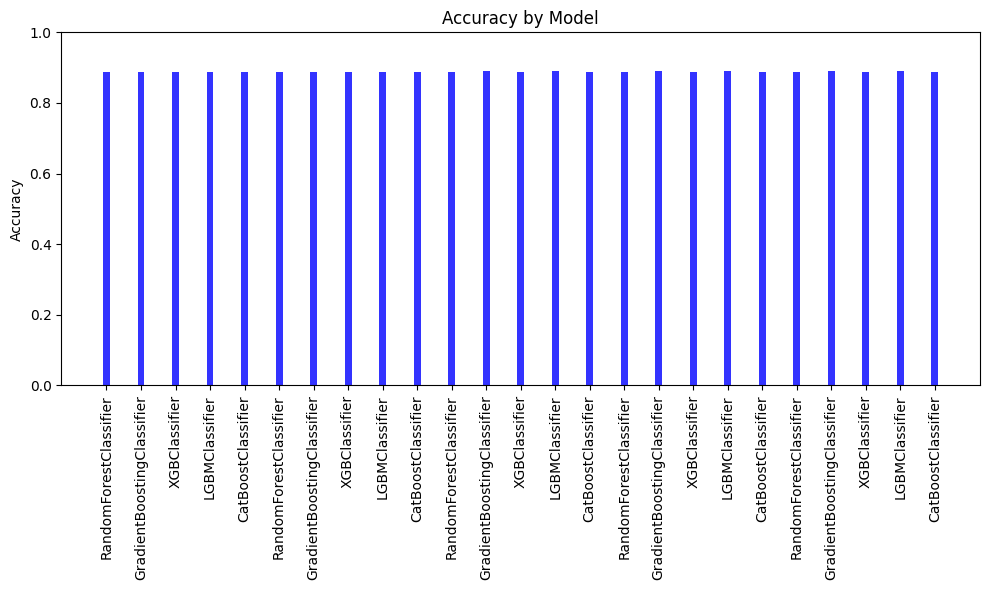

In [100]:
models = classification_reports['model']
accuracy = classification_reports['accuracy']

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting accuracy for each model as grouped bars
bar_width = 0.2  # Adjust the width between bars as needed
x = range(len(models))

for i, acc in enumerate(accuracy):
    ax.bar(x[i], acc, width=bar_width, color='blue', alpha=0.8, label=models[i])

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)  # Set y-axis limits for accuracy (0 to 1)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('drive/MyDrive/diabetes/accuracyAll.png')
plt.show()